In [19]:
import geopandas as gpd
import pandas as pd

import json
import osm2geojson
import requests

import datetime

# get geometry

In [33]:
shape_name= "Neukölln"
shape_name_str=shape_name.replace("ö","oe")

In [21]:
## Should use [out:json] in the query as later osmtogeojson does not parse XML
query = """
[out:json][timeout:25];
area[name="Berlin"]->.searchArea;
(relation["admin_level"="9"]["name"="Neukölln"](area.searchArea););
out body;
>;
out skel qt;
"""

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})#,  proxies=proxies)

res_geojson = osm2geojson.json2geojson(r.json())

### Bundesland

In [27]:
shape_name= "Hessen"
shape_name_str=shape_name.replace("ö","oe")

In [34]:
## Should use [out:json] in the query as later osmtogeojson does not parse XML
query = """
[out:json][timeout:25];
area[name="Hessen"]->.searchArea;
(relation["admin_level"="4"](area.searchArea););
out body;
>;
out skel qt;
"""

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})#,  proxies=proxies)

res_geojson = osm2geojson.json2geojson(r.json())

## Deutschland

In [43]:
shape_name= "Deutschland"
shape_name_str=shape_name.replace("ö","oe")

In [47]:
## Should use [out:json] in the query as later osmtogeojson does not parse XML
query = """
[out:json][timeout:25];
// Get the Germany boundary as a relation
rel[admin_level=2]["ISO3166-1"="DE"];
out body;
>;
out skel qt;
"""

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})#,  proxies=proxies)

res_geojson = osm2geojson.json2geojson(r.json())

<Axes: >

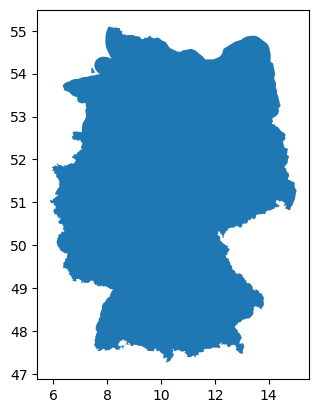

In [48]:
gdf_osm_shape = gpd.GeoDataFrame.from_features(res_geojson, crs="4326")
gdf_osm_shape_poly=gdf_osm_shape[gdf_osm_shape["type"]=="relation"]
gdf_osm_shape_poly.plot()

In [49]:
# fixing hessen
#gdf_osm_shape_poly=gdf_osm_shape_poly[gdf_osm_shape_poly["id"]==62650]
#gdf_osm_shape_poly.plot()

In [50]:
gdf_osm_shape_poly.to_file("osm_files/"+ shape_name_str+ "_poly_shape.geojson")

In [51]:
#gdf_osm_shape_poly.buffer(0.0001)

In [52]:
import subprocess

def run_osmium(year):
    try:
        # Set file paths inside the "osm_files" folder
        base_dir = "osm_files/"
        input_pbf = base_dir + "germany-"+year+"0101.osm.pbf"
        #polygon_geojson = base_dir + "berlin.geojson"
        polygon_geojson = base_dir + shape_name_str+ "_poly_shape.geojson"
        extracted_pbf = base_dir + shape_name_str + "_" + year + ".pbf"
        filtered_pbf = base_dir + shape_name_str + "_roads_" + year + ".pbf"
        #output_geojson = base_dir + "berlin_roads_new.geojson"

        # Extract area using a GeoJSON polygon
        extract_command = [
            "osmium", "extract",
            "--polygon=" + polygon_geojson,
            "-o", extracted_pbf,
            input_pbf
        ]
        print("🔹 Running: ", " ".join(extract_command))
        subprocess.run(extract_command, check=True)

        # Filter highways (primary, secondary, tertiary, and links)
        filter_command = [
            "osmium", "tags-filter",
            extracted_pbf,
            "w/highway=primary,primary_link,secondary,secondary_link,tertiary,tertiary_link",
            "-o", filtered_pbf
        ]
        print("🔹 Running: ", " ".join(filter_command))
        subprocess.run(filter_command, check=True)

        ## Convert extracted roads to GeoJSON
        #convert_command = [
        #    "osmium", "export",
        #    "-o", output_geojson,
        #    filtered_pbf
        #]
        #print("🔹 Running: ", " ".join(convert_command))
        #subprocess.run(convert_command, check=True)

        print("✅ Osmium processing complete! Files saved in 'osm_files/'")

    except subprocess.CalledProcessError as e:
        print("❌ Error running Osmium:", e)

# Run the function

for y in ["17", "24"]:
    run_osmium(y)


🔹 Running:  osmium extract --polygon=osm_files/Deutschland_poly_shape.geojson -o osm_files/Deutschland_17.pbf osm_files/germany-170101.osm.pbf
🔹 Running:  osmium tags-filter osm_files/Deutschland_17.pbf w/highway=primary,primary_link,secondary,secondary_link,tertiary,tertiary_link -o osm_files/Deutschland_roads_17.pbf
✅ Osmium processing complete! Files saved in 'osm_files/'
🔹 Running:  osmium extract --polygon=osm_files/Deutschland_poly_shape.geojson -o osm_files/Deutschland_24.pbf osm_files/germany-240101.osm.pbf
🔹 Running:  osmium tags-filter osm_files/Deutschland_24.pbf w/highway=primary,primary_link,secondary,secondary_link,tertiary,tertiary_link -o osm_files/Deutschland_roads_24.pbf
✅ Osmium processing complete! Files saved in 'osm_files/'
